# Create population masks for regions

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:00:00"
cores = 4
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.2:33105,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
import xarray as xr
import numpy as np
from pyproj import Transformer
import xesmf as xe

## For Australia

From https://www.abs.gov.au/statistics/people/population/regional-population/2021-22#cite-window1 (Australian population grid 2022 in GeoTIFF format) [Accessed 06/07/2023]

In [10]:
# Open tif and drop band dimension
pop = xr.open_rasterio(
    "/g/data/w42/dr6273/work/data/ABS/apg22r_1_0_0.tif",
    chunks={"x": 500, "y": 200}
).squeeze("band", drop=True)

/jobfs/89849561.gadi-pbs/ipykernel_3927883/2295892030.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  pop = xr.open_rasterio(


In [11]:
pop

<xarray.DataArray (y: 4100, x: 7401)>
dask.array<getitem, shape=(4100, 7401), dtype=float32, chunksize=(200, 500), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -1e+06 -1.002e+06 -1.002e+06 ... -5.098e+06 -5.1e+06
  * x        (x) float64 -3.9e+06 -3.9e+06 -3.898e+06 ... 3.498e+06 3.5e+06
Attributes:
    transform:      (1000.0, 0.0, -3901000.0, 0.0, -1000.0, -1000000.0)
    crs:            +init=epsg:3577
    res:            (1000.0, 1000.0)
    is_tiled:       1
    nodatavals:     (-1.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('Band_1',)
    AREA_OR_POINT:  Area

Ocean cells are masked with -1, and many land cells are 0 (no population density). To check what we have is sensible, set the scale max to 3:

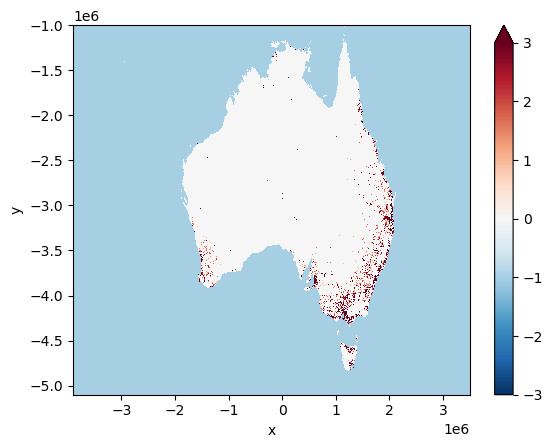

In [16]:
pop.plot.imshow(vmax=3)

According to the attributes, this raster is in the coordinate system EPSG:3577, which in in metres: https://epsg.io/3577

We want to transform to EPSG:4326, which is in lat/lon: https://epsg.io/4326

In [17]:
transformer = Transformer.from_crs("EPSG:3577", "EPSG:4326", always_xy=True)

Apply the transformation - this takes quite a bit of time, so first reduce the size of the array using `.sel` with trial and error of the values, to get as close to Australia as possible.

In [25]:
subset = pop.isel(
    x=range(1950, 6050),
    y=range(100, 3900)
)
# subset = pop.isel(
#     x=range(4500, 5500),
#     y=range(2500, 4000)
# )

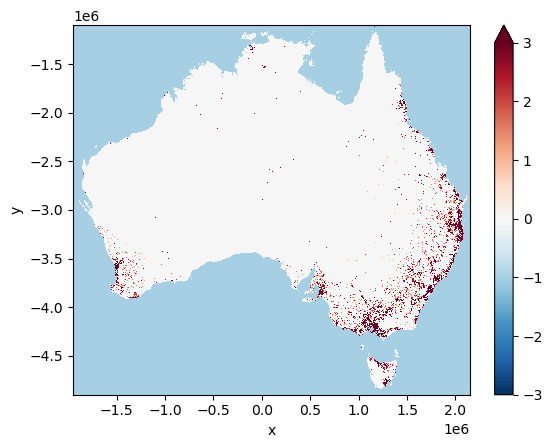

In [26]:
subset.plot.imshow(vmax=3)

In [27]:
# Create rectangular grid
X, Y = np.meshgrid(subset.x.values, subset.y.values)

In [28]:
# We have gone from a 4100x7401 grid to 3800x4100
print(X.shape, Y.shape)

(3800, 4100) (3800, 4100)


In [29]:
%%time
lon, lat = transformer.transform(X, Y)

CPU times: user 12min 19s, sys: 10min 32s, total: 22min 51s
Wall time: 1h 15min 29s


In [30]:
subset.coords['lat'] = (subset.dims, lat)
subset.coords['lon'] = (subset.dims, lon)

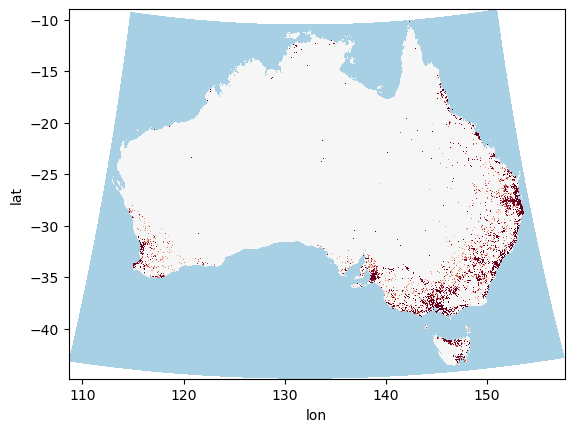

In [35]:
subset.plot.pcolormesh('lon', 'lat', add_colorbar=False, vmax=3)

Write to file so we don't have to compute again

In [40]:
subset.to_dataset(name="population_density").to_netcdf("/g/data/w42/dr6273/work/data/ABS/apg22r_1_0_0.nc")

### Regrid to ERA5

In [2]:
pop = xr.open_dataset("/g/data/w42/dr6273/work/data/ABS/apg22r_1_0_0.nc")["population_density"]

In [10]:
pop

<xarray.DataArray 'population_density' (y: 3800, x: 4100)>
[15580000 values with dtype=float32]
Coordinates:
  * y        (y) float64 -1.1e+06 -1.102e+06 -1.102e+06 ... -4.898e+06 -4.9e+06
  * x        (x) float64 -1.95e+06 -1.95e+06 -1.948e+06 ... 2.148e+06 2.148e+06
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
Attributes:
    transform:      [ 1.000e+03  0.000e+00 -3.901e+06  0.000e+00 -1.000e+03 -...
    crs:            +init=epsg:3577
    res:            [1000. 1000.]
    is_tiled:       1
    nodatavals:     -1.0
    scales:         1.0
    offsets:        0.0
    descriptions:   Band_1
    AREA_OR_POINT:  Area

In [37]:
import matplotlib.pyplot as plt

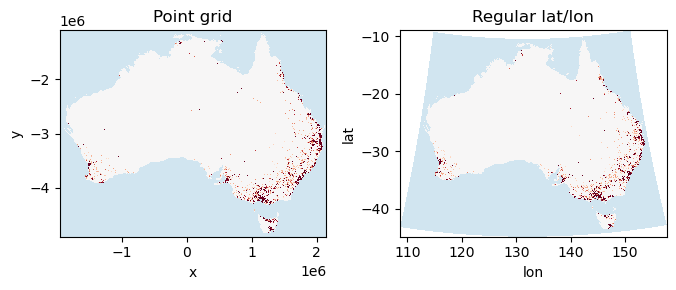

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

pop.plot.imshow(ax=ax[0], add_colorbar=False, vmax=5)
pop.plot.pcolormesh("lon", "lat", ax=ax[1], add_colorbar=False, vmax=5)

ax[0].set_title("Point grid")
ax[1].set_title("Regular lat/lon")

plt.tight_layout()

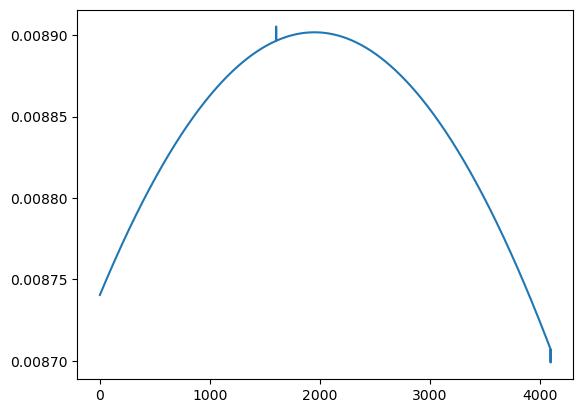

In [39]:
plt.plot(np.diff(pop.isel(y=0)["lon"].values))

Get ERA5 template and subset for Australia

In [3]:
template = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/1959/2t_era5_moda_sfc_19590101-19590131.nc"
)

In [4]:
template = template["t2m"].sel(longitude=slice(108, 158), latitude=slice(-8, -45))

Use the coordinates to set up the desired output grid

In [14]:
ds_out = xr.Dataset({
    "lat": (["lat"], template["latitude"].values, {"units": "degrees_north"}),
    "lon": (["lon"], template["longitude"].values, {"units": "degrees_east"}),
})

In [15]:
regridder = xe.Regridder(pop, ds_out, "conservative")

In [16]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_3800x4100_149x201.nc 
Reuse pre-computed weights? False 
Input grid shape:           (3800, 4100) 
Output grid shape:          (149, 201) 
Periodic in longitude?      False

In [17]:
new = regridder(pop, keep_attrs=True)

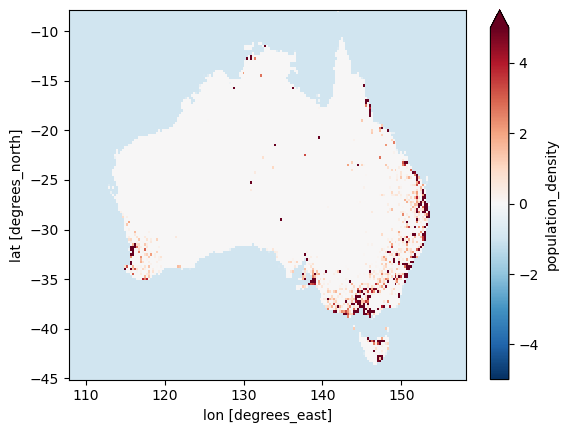

In [18]:
new["population_density"].plot(vmax=5)

In [19]:
new["population_density"].max()

<xarray.DataArray 'population_density' ()>
array(4060.53588867)

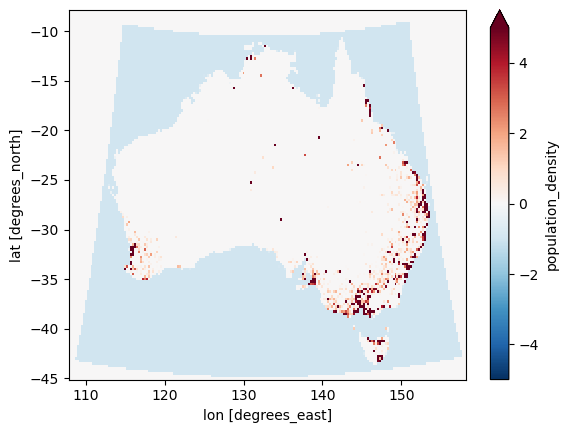

In [116]:
new["population_density"].plot(vmax=5)

In [115]:
subset.max().values

array(28384.754, dtype=float32)